# This notebook shows the dataset preprocessing
- input normalization
- output scaling

In [1]:
import gcsfs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

## [1] Load dataset

In [2]:
fs = gcsfs.GCSFileSystem()
print(fs.ls("gs://leap-persistent-ro/sungdukyu"))
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
ds_train_in = xr.open_dataset(mapper, engine='zarr', chunks={})
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds_train_out = xr.open_dataset(mapper, engine='zarr', chunks={})

# grid info
mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
ds_grid = xr.open_dataset(mapper, engine='zarr')

# #<Saving toy dataset>
# ds_train_in.isel(sample=slice(0,4)).to_zarr('./toy_dataset/E3SM-MMF_ne4.train.input.tiny.zarr')
# ds_train_out.isel(sample=slice(0,4)).to_zarr('./toy_dataset/E3SM-MMF_ne4.train.output.tiny.zarr')

['leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr', 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.test.input.zarr', 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.test.output.zarr', 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr', 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr', 'leap-persistent-ro/sungdukyu/testing']


## [2] Determine in/out variables; subsampling

In [3]:
# in/out variable lists (these are subset of dataset variables)
vars_mli = ['state_t','state_q0001','state_ps','pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX']

vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC',
            'cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']

In [4]:
# select ML variables
# note that otuput variables are tendencies, not state (for t and q)
mli = ds_train_in[vars_mli]
mlo = ds_train_out
mlo['ptend_t']     = (mlo['state_t'] - mli['state_t'])/1200 # T tendency [K/s]
mlo['ptend_q0001'] = (mlo['state_q0001'] - mli['state_q0001'])/1200 # Q tendency [kg/kg/s]
mlo = mlo[vars_mlo] 

In [5]:
# sub sampling dataset for tutorial purpose only
if True: 
    stride = 701
    mli = mli.isel(sample=slice(0,None,stride))
    mlo = mlo.isel(sample=slice(0,None,stride))
mli['sample'].__len__()

300

Now, we only have 1/701 of total samples, that is only 300.\
However, for the real use for ML, subsampling should be kept at minimum or not used at all.

### [3] Input / output normalization
We want to calculate summary statistics for normalizing ML inputs, e.g., mean, min, and max.\
In the dataset, the dimension of a variable can be:
- 2D, e.g., pbuf_SOLIN = pbuf_SOLIN(sample, ncol)
- 3D, e.g., state_T = state_t(sample, lev, ncol)

We will calculate summary statistics through only sample and ncol dimensions.


In [6]:
mli_mean = mli.mean(dim=['sample', 'ncol'])
mli_min  = mli.min(dim=['sample', 'ncol'])
mli_max  = mli.max(dim=['sample', 'ncol'])
mli_std  = mli.std(dim=['sample', 'ncol'])

now see that the calculated stastic is either a scalar or a 1-D array, depending on the dimension of the original variable.

In [7]:
mli_mean['pbuf_SOLIN'].values

array(340.48662836)

In [8]:
# # Processing vertically-resolved variables (e.g., state_t, state_q0001) takes longer than processing surface variables, e.g., pbuf_SOLIN.
# mli_mean['state_t'].values

save the calculated statistics to netcdf files

In [9]:
if False:
    mli_mean.to_netcdf('./norm_factors/mli_mean.tutorial.nc') # i changed the file name to avoid accidental overwriting of the original files
    mli_min.to_netcdf('./norm_factors/mli_min.tutorial.nc')
    mli_max.to_netcdf('./norm_factors/mli_max.tutorial.nc')
    mli_std.to_netcdf('./norm_factors/mli_std.tutorial.nc')
else:
    mli_mean = xr.open_dataset('./norm_factors/mli_mean.nc')
    mli_min  = xr.open_dataset('./norm_factors/mli_min.nc')
    mli_max  = xr.open_dataset('./norm_factors/mli_max.nc')
    mli_std  = xr.open_dataset('./norm_factors/mli_std.nc')

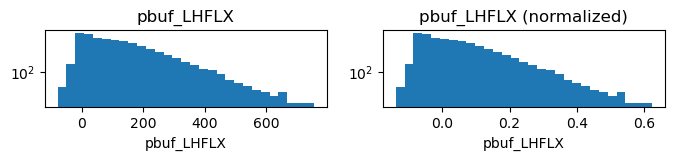

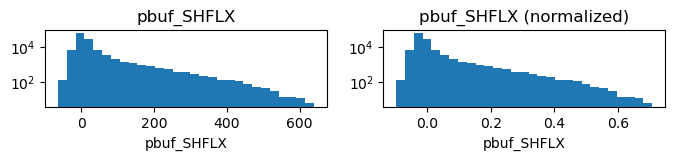

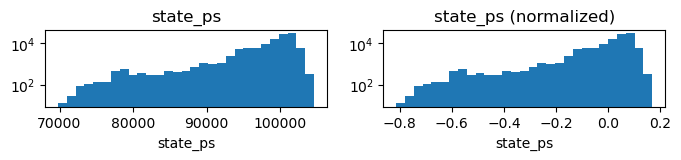

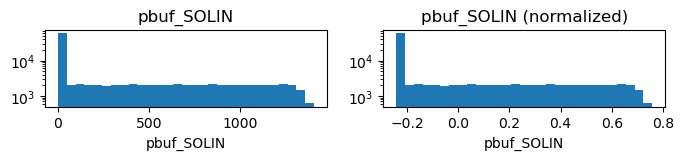

In [10]:
# before and after input norm
# pbuf_COSZRS, pbuf_LHFLX, pbuf_SHFLX, pbuf_SOLIN, pbuf_TAUX, pbuf_TAUY, state_ps
# state_q0001, state_q0002, state_q0003, state_t, state_u, state_v, state_pmid
for kvar in ['pbuf_LHFLX', 'pbuf_SHFLX', 'state_ps', 'pbuf_SOLIN']:
    fig, ax_ = plt.subplots(ncols=2)
    ax = ax_[0]
    mli[kvar].plot.hist(bins=29,ax=ax)
    ax.set_title(kvar)
    ax.set_yscale('log')
    ax = ax_[1]
    ((mli[kvar] - mli_mean[kvar])/(mli_max[kvar] - mli_min[kvar])).plot.hist(bins=29,ax=ax)
    ax.set_title(f'{kvar} (normalized)')
    ax.set_yscale('log')
    fig.set_size_inches(8,1)
    


Now time to scale output variables!\
for ptend_t and ptend_q0001, are converted common energy unit, e.g.,\
- ptend_t * cp  [W/m2]
- ptend_q * (lv+lf)  [w/m2]

They have comparable scale (with some physical reasons).\
For the rest of variables, matching scale to the above two.\
Why do this? to make optimizer feel every variables

In [11]:
if False:
    mlo_scale = xr.Dataset({'ptend_t':        ('lev', 1.00464e3 * np.ones(mlo.dims['lev'])), # J/K/kg
                            'ptend_q0001':    ('lev', (2.501e6 + 3.337e5)*np.ones(mlo.dims['lev'])), # J/kg
                            'cam_out_NETSW':  1e-2 *0.24,
                            'cam_out_FLWDS':  1e-2 *.5,
                            'cam_out_PRECSC': 17280000 * .72,
                            'cam_out_PRECC':  1728000 * .76,
                            'cam_out_SOLS':   1e-2 * .5,
                            'cam_out_SOLL':   1e-2 * .46,
                            'cam_out_SOLSD':  1e-2 * .61,
                            'cam_out_SOLLD':  1e-2 * .95
                           })
    mlo_scale.to_netcdf('./norm_factors/mlo_scale.tutorial.nc') # i changed the file name to avoid accidental overwriting of the original files
else:
    mlo_scale = xr.open_dataset('./norm_factors/mlo_scale.nc')

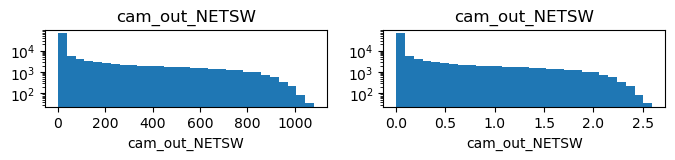

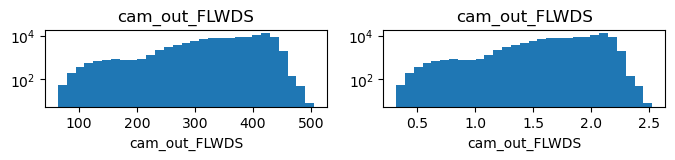

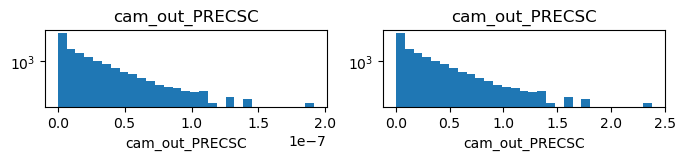

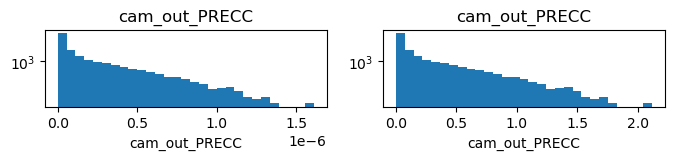

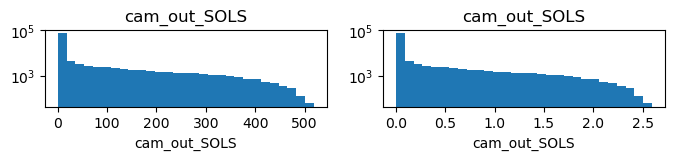

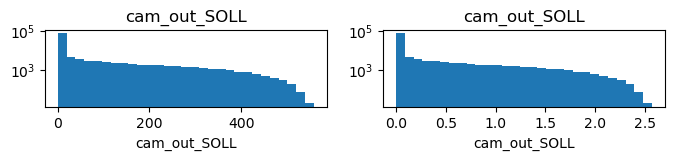

In [12]:
# before and after output scaling
for kvar in ['cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL']:
    fig, ax_ = plt.subplots(ncols=2)
    ax = ax_[0]
    mlo[kvar].plot.hist(bins=29,ax=ax)
    ax.set_title(kvar)
    ax.set_yscale('log')
    fig.set_size_inches(8,1.5)
    ax = ax_[1]
    (mlo[kvar]*mlo_scale[kvar]).plot.hist(bins=29,ax=ax)
    ax.set_title(kvar)
    ax.set_yscale('log')
    fig.set_size_inches(8,1)

In [14]:
# # again, processing vertical-resolved variables takes linger.
# for kvar in ['ptend_t', 'ptend_q0001']:
#     fig, ax_ = plt.subplots(ncols=2)
#     ax = ax_[0]
#     mlo[kvar].plot.hist(bins=29,ax=ax)
#     ax.set_title(kvar)
#     ax.set_yscale('log')
#     ax = ax_[1]
#     (mlo[kvar]*mlo_scale[kvar]).plot.hist(bins=29,ax=ax)
#     ax.set_title(kvar)
#     ax.set_yscale('log')
#     fig.set_size_inches(8,1.5)